# Term Project 2

### Aidana Bolat - A0219532H

In [1]:
import QuantLib as ql
import math
from scipy.stats import norm
import pandas as pd
import numpy as np
#import scipy.interpolate
from scipy import interpolate


## Q1

In [2]:
vol_data=pd.read_csv('vol_data.csv')
tenor=vol_data['USD/JPY']
vol_data.index=tenor
vol_data.drop(columns=['USD/JPY'],axis=1,inplace=True)
vol_data

,ATM,RR 25,RR 10,BF 25,BF 10
USD/JPY,,,,,
O/N,7.00,0.30,0.60,0.35,1.10
1W,8.75,-0.05,-0.05,0.25,0.75
1M,7.65,-0.75,-1.40,0.35,1.10
2M,7.45,-1.00,-1.85,0.35,1.15
3M,7.35,-1.05,-2.40,0.35,1.25
6M,7.30,-1.25,-2.65,0.40,1.35
1Y,7.50,-1.35,-2.85,0.40,1.50
2Y,7.45,-1.40,-2.90,0.40,1.75
3Y,7.50,-1.45,-2.80,0.45,2.00


In [3]:
USDRate = 0.03
JPYRate=0.01
USDJPY_spot=120
DayCount =  ql.Actual365Fixed()
USDCalendar = ql.UnitedStates()
JPYCalendar=ql.Japan()
Frequency = ql.Semiannual
Compounding = ql.Compounded
quoteDate=ql.Date(14,3,2022)
ql.Settings.instance().evaluationDate = quoteDate
USDYieldCurveHandle = ql.YieldTermStructureHandle(
ql.FlatForward(0,USDCalendar,ql.QuoteHandle(ql.SimpleQuote(USDRate)), DayCount, Compounding, Frequency))
JPYYieldCurveHandle = ql.YieldTermStructureHandle(
ql.FlatForward(0,JPYCalendar,ql.QuoteHandle(ql.SimpleQuote(JPYRate)), DayCount, Compounding, Frequency))


Calculation for Option Volatility

In [4]:
Put_Vol_10D_m=[round(vol_data['ATM'][i]+0.5*(2*vol_data['BF 10'][i]-vol_data['RR 10'][i]),2)for i in range(len(vol_data))]
Put_Vol_25D_m=[round(vol_data['ATM'][i]+0.5*(2*vol_data['BF 25'][i]-vol_data['RR 25'][i]),2)for i in range(len(vol_data))]
ZDS_ATM_Vol=vol_data['ATM']
Call_Vol_25D=[round(vol_data['ATM'][i]+0.5*(vol_data['RR 25'][i]+2*vol_data['BF 25'][i]),2)for i in range(len(vol_data))]
Call_Vol_10D=[round(vol_data['ATM'][i]+0.5*(vol_data['RR 10'][i]+2*vol_data['BF 10'][i]),2)for i in range(len(vol_data))]
pd.DataFrame({'-10D Put Vol':Put_Vol_10D_m,'-25D Put Vol':Put_Vol_25D_m,'ZDS/ATMVol':ZDS_ATM_Vol,'25D Call Vol':Call_Vol_25D,'10D Call Vol':Call_Vol_10D})


,-10D Put Vol,-25D Put Vol,ZDS/ATMVol,25D Call Vol,10D Call Vol
USD/JPY,,,,,
O/N,7.80,7.20,7.00,7.50,8.40
1W,9.52,9.02,8.75,8.98,9.48
1M,9.45,8.38,7.65,7.62,8.05
2M,9.52,8.30,7.45,7.30,7.68
3M,9.80,8.22,7.35,7.18,7.40
6M,9.98,8.32,7.30,7.08,7.32
1Y,10.42,8.57,7.50,7.22,7.58
2Y,10.65,8.55,7.45,7.15,7.75
3Y,10.90,8.68,7.50,7.22,8.10


Calculation on Strike

In [5]:
SpotDate=JPYCalendar.advance(quoteDate,ql.Period('2D'))
Delivery_date=[JPYCalendar.advance(SpotDate,ql.Period('1D'))]
Delivery_date+=[JPYCalendar.advance(SpotDate,ql.Period(vol_data.index[i])) for i in range(1,len(vol_data))]
Expiry_date=[JPYCalendar.advance(Delivery_date[i],ql.Period('-2D'))for i in range(len(Delivery_date))]
Time_to_Expiry=[DayCount.yearFraction(quoteDate,Expiry_date[i]) for i in range(len(vol_data))]
For_Disc_Fact=[USDYieldCurveHandle.discount(Expiry_date[i]) for i in range(len(vol_data))]
Dom_Disc_Fact=[JPYYieldCurveHandle.discount(Expiry_date[i]) for i in range(len(vol_data))]
Fwd_Fx=[USDJPY_spot*For_Disc_Fact[i]/Dom_Disc_Fact[i] for i in range(len(vol_data))]
Put_Strike_10D=[Fwd_Fx[i]*math.exp(Put_Vol_10D_m[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.1/For_Disc_Fact[i],0,1)+0.5*((Put_Vol_10D_m[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(vol_data))]
Put_Strike_25D=[Fwd_Fx[i]*math.exp(Put_Vol_25D_m[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.25/For_Disc_Fact[i],0,1)+0.5*((Put_Vol_25D_m[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(vol_data))]
ZDS_ATM_Strike=[Fwd_Fx[i]*math.exp(0.5*((ZDS_ATM_Vol[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(vol_data))]
Call_Strike_10D=[Fwd_Fx[i]*math.exp(-Call_Vol_10D[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.1/For_Disc_Fact[i],0,1)+0.5*((Call_Vol_10D[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(vol_data))]
Call_Strike_25D=[Fwd_Fx[i]*math.exp(-Call_Vol_25D[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.25/For_Disc_Fact[i],0,1)+0.5*((Call_Vol_25D[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(vol_data))]

table1=pd.DataFrame({'10D Put Strike':Put_Strike_10D,'25D Put Strike':Put_Strike_25D,'ZDS/ATM Strike':ZDS_ATM_Strike,'25D Call Strike':Call_Strike_25D,'10D Call Strike':Call_Strike_10D,})
table1.index=tenor
table1

,10D Put Strike,25D Put Strike,ZDS/ATM Strike,25D Call Strike,10D Call Strike
USD/JPY,,,,,
O/N,119.368317,119.689743,119.994295,120.312530,120.672664
1W,118.457508,119.217890,119.978995,120.742138,121.515327
1M,115.692375,117.882040,119.828127,121.630852,123.484624
2M,113.986138,117.034216,119.670177,122.047010,124.493537
3M,112.265651,116.252082,119.483866,122.394628,125.291556
6M,108.833374,114.446827,118.967755,122.987483,127.105805
1Y,103.684837,111.673553,117.978464,123.629704,129.854255
2Y,96.660310,107.694643,115.976903,123.517841,133.039563
3Y,91.257621,104.457320,114.036984,122.887850,135.706465


## Q2

In [6]:
def FXVolatility(Fwd_Fx,Time_to_Expiry,Strike,Type):
    if Type=='ZDS_ATM':
        vol=math.sqrt(math.log(Strike/Fwd_Fx)*2/Time_to_Expiry)*100
    else:
        if Type=='Call_10D':
            fun=lambda vol: abs(Fwd_Fx*math.exp(-vol/100*math.sqrt(Time_to_Expiry)*norm.ppf(0.1/USDYieldCurveHandle.discount(Time_to_Expiry),0,1)+0.5*((vol/100)**2)*Time_to_Expiry)-Strike)
        elif Type=='Call_25D':
            fun=lambda vol: abs(Fwd_Fx*math.exp(-vol/100*math.sqrt(Time_to_Expiry)*norm.ppf(0.25/USDYieldCurveHandle.discount(Time_to_Expiry),0,1)+0.5*((vol/100)**2)*Time_to_Expiry)-Strike)
        elif Type=='Put_10D':
            fun=lambda vol: abs(Fwd_Fx*math.exp(vol/100*math.sqrt(Time_to_Expiry)*norm.ppf(0.1/USDYieldCurveHandle.discount(Time_to_Expiry),0,1)+0.5*((vol/100)**2)*Time_to_Expiry)-Strike)
        else:
            fun=lambda vol: abs(Fwd_Fx*math.exp(vol/100*math.sqrt(Time_to_Expiry)*norm.ppf(0.25/USDYieldCurveHandle.discount(Time_to_Expiry),0,1)+0.5*((vol/100)**2)*Time_to_Expiry)-Strike)
                
        maxIterations = 1000
        minStatIterations = 100
        rootEpsilon = 1e-6
        functionEpsilon = 1e-6
        gradientNormEpsilon = 1e-6
 
        myEndCrit = ql.EndCriteria(
            maxIterations,
            minStatIterations,
            rootEpsilon,
            functionEpsilon,
            gradientNormEpsilon)

        startVal = ql.Array(1)
        startVal[0] = 17

 
        constraint = ql.PositiveConstraint()
        solver = ql.BFGS()

        minimize = ql.Optimizer()

        min1 = minimize.solve(
            function=fun,
            c=constraint,
            m=solver,
            e=myEndCrit,
            iv=startVal)
        vol=list(min1)[0]
    return round(vol,2)

In [7]:
reproduce_ZDS_ATM_Vol=[FXVolatility(Fwd_Fx[i],Time_to_Expiry[i],ZDS_ATM_Strike[i],'ZDS_ATM') for i in range(len(ZDS_ATM_Strike))]
reproduce_Put_Vol_10D_m=[FXVolatility(Fwd_Fx[i],Time_to_Expiry[i],Put_Strike_10D[i],'Put_10D') for i in range(len(Put_Strike_10D))]
reproduce_Put_Vol_25D_m=[FXVolatility(Fwd_Fx[i],Time_to_Expiry[i],Put_Strike_25D[i],'Put_25D') for i in range(len(Put_Strike_25D))]
reproduce_Call_Vol_10D=[FXVolatility(Fwd_Fx[i],Time_to_Expiry[i],Call_Strike_10D[i],'Call_10D') for i in range(len(Call_Strike_10D))]
reproduce_Call_Vol_25D=[FXVolatility(Fwd_Fx[i],Time_to_Expiry[i],Call_Strike_25D[i],'Call_25D') for i in range(len(Call_Strike_25D))]

Check Consistency

In [8]:
table2=pd.DataFrame({'reproduced -10D Put Vol':reproduce_Put_Vol_10D_m,'reproduced -25D Put Vol':reproduce_Put_Vol_25D_m,'reproduced ZDS/ATMVol':reproduce_ZDS_ATM_Vol,'reproduced 25D Call Vol':reproduce_Call_Vol_25D,'reproduced 10D Call Vol':reproduce_Call_Vol_10D})
table2.index=tenor
table2

,reproduced -10D Put Vol,reproduced -25D Put Vol,reproduced ZDS/ATMVol,reproduced 25D Call Vol,reproduced 10D Call Vol
USD/JPY,,,,,
O/N,7.80,7.20,7.00,7.50,8.40
1W,9.52,9.02,8.75,8.98,9.48
1M,9.45,8.38,7.65,7.62,8.05
2M,9.52,8.30,7.45,7.30,7.68
3M,9.80,8.22,7.35,7.18,7.40
6M,9.98,8.32,7.30,7.08,7.32
1Y,10.42,8.57,7.50,7.22,7.58
2Y,10.65,8.55,7.45,7.15,7.75
3Y,10.90,8.68,7.50,7.22,8.10


Compare table1 in Q1, the function is giving the input volatilities

## Q3

In [9]:
volTS = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(2, ql.NullCalendar(), 0.2, ql.Actual365Fixed()))
process=ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(120)),USDYieldCurveHandle,JPYYieldCurveHandle,volTS)
option = ql.BarrierOption(ql.Barrier.DownOut, 115, 0, ql.PlainVanillaPayoff(ql.Option.Call, 125),  ql.EuropeanExercise(Expiry_date[8]))
engine=ql.AnalyticBarrierEngine(process)
option.setPricingEngine(engine)

print('Premium: ',(option.NPV()/USDJPY_spot)*25000000)


Premium:  627120.7524779729


## Q4.
### We will do delta hedging of a portfolio by taking M amount of JPY money. So in our portfolio we have: 1 barrier option and M JPY. 

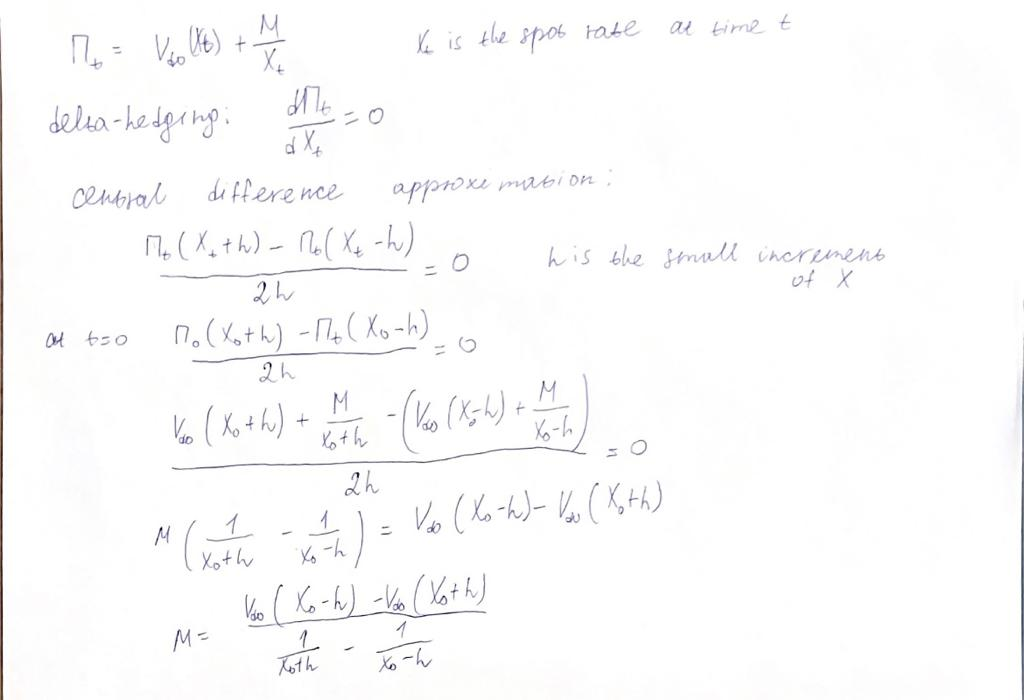

In [10]:
def barriorOptionCalculator(vol,USDJPY_spot):   
    volTS = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(2, ql.NullCalendar(), vol, ql.Actual365Fixed()))
    process=ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(USDJPY_spot)),USDYieldCurveHandle,JPYYieldCurveHandle,volTS)
    option = ql.BarrierOption(ql.Barrier.DownOut, 115, 0, ql.PlainVanillaPayoff(ql.Option.Call, 125),  ql.EuropeanExercise(Expiry_date[8]))
    engine=ql.AnalyticBarrierEngine(process)
    option.setPricingEngine(engine)
    return (option.NPV()/USDJPY_spot)*25000000


h=0.00001
vol=0.2
V1= barriorOptionCalculator(vol,USDJPY_spot+h)/25000000  #price of option for X+h initial spot rate with N=1
V2=barriorOptionCalculator(vol,USDJPY_spot-h)/25000000   #price of option for X-h initial spot rate with N=1

M=(V2-V1)/(1/(USDJPY_spot+h)-1/(USDJPY_spot-h))
print('The amount of JPY needed:M=',M)


The amount of JPY needed:M= 70.71192936274397


In [11]:
def volcalc(data):
    Put_Vol_10D_m=[round(data[i][0]+0.5*(2*data[i][4]-data[i][2]),2)for i in range(len(data))]
    Put_Vol_25D_m=[round(data[i][0]+0.5*(2*data[i][3]-data[i][1]),2)for i in range(len(data))]
    Call_Vol_25D=[round(data[i][0]+0.5*(data[i][1]+2*data[i][3]),2)for i in range(len(data))]
    Call_Vol_10D=[round(data[i][0]+0.5*(data[i][2]+2*data[i][4]),2)for i in range(len(data))]
    ZDS_ATM_Vol=[data[i][0] for i in range(len(data))]
    Fwd_Fx=[USDJPY_spot*For_Disc_Fact[i]/Dom_Disc_Fact[i] for i in range(len(data))]
    Put_Strike_10D=[Fwd_Fx[i]*math.exp(Put_Vol_10D_m[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.1/For_Disc_Fact[i],0,1)+0.5*((Put_Vol_10D_m[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(data))]
    Put_Strike_25D=[Fwd_Fx[i]*math.exp(Put_Vol_25D_m[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.25/For_Disc_Fact[i],0,1)+0.5*((Put_Vol_25D_m[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(data))]
    ZDS_ATM_Strike=[Fwd_Fx[i]*math.exp(0.5*((ZDS_ATM_Vol[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(data))]
    Call_Strike_10D=[Fwd_Fx[i]*math.exp(-Call_Vol_10D[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.1/For_Disc_Fact[i],0,1)+0.5*((Call_Vol_10D[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(data))]
    Call_Strike_25D=[Fwd_Fx[i]*math.exp(-Call_Vol_25D[i]/100*math.sqrt(Time_to_Expiry[i])*norm.ppf(0.25/For_Disc_Fact[i],0,1)+0.5*((Call_Vol_25D[i]/100)**2)*Time_to_Expiry[i]) for i in range(len(data))]
    return Put_Vol_10D_m,Put_Vol_25D_m,Call_Vol_25D,Call_Vol_10D,ZDS_ATM_Vol,Put_Strike_10D, Put_Strike_25D,ZDS_ATM_Strike,Call_Strike_10D,Call_Strike_25D

In [12]:
#original volatilities
volinputs=[[7.00,0.30,0.60,0.35,1.10],
                    [8.75,-0.05,-0.05,0.25,0.75],
                    [7.65,-0.75,-1.4,0.35,1.1],
                    [7.45,-1,-1.85,0.35,1.15],
                    [7.35,-1.05,-2.4,0.35,1.25],
                    [7.3,-1.25,-2.65,0.4,1.35],
                    [7.5,-1.35,-2.85,0.4,1.5],
                    [7.45,-1.4,-2.9,0.4,1.75],
                    [7.5,-1.45,-2.8,0.45,2],
                    [7.55,-1.5,-2.85,0.5,2.25],
                    [7.55,-1.5,-2.7,0.55,2.5],
                    [7.65,-2,-3.4,0.55,2.75],
                    [8.5,-4,-7,0.25,2.8],
                    [8.75,-4.5,-7.75,0.5,2.1],
                    [9.5,-5,-8.5,0.55,2.15],
                    [9.75,-5.5,-9.25,0.6,2.2],
                    [10,-5.75,-9.5,0.65,2.25],
                    [10.25,-6,-9.75,0.7,2.3]]

In [13]:
#function constructs volatility surface and return volatility for given strike
def FXVolatility1(inputvol,strike,Expiry_date):
     
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10=volcalc(inputvol)
    Strikes_=[a6[8],a7[8],a8[8],a9[8],a10[8]] 
    VolMatrix=ql.Matrix(5,len(vol_data))
    for i in range(len(vol_data)):
            VolMatrix[0][i]=a1[i]
            VolMatrix[1][i]=a2[i]
            VolMatrix[2][i]=a3[i]
            VolMatrix[3][i]=a4[i]
            VolMatrix[4][i]=a5[i]
    VolSurface=ql.BlackVarianceSurface(quoteDate, ql.TARGET(), Expiry_date, Strikes_, VolMatrix, DayCount)
    VolSurface.enableExtrapolation()
    vol_=VolSurface.blackVol(quoteDate, strike)
    return vol_
    

In [14]:
#Original NPV
vol=FXVolatility1(volinputs,125,Expiry_date)
originalNPV=barriorOptionCalculator(vol/100,120)
print(originalNPV)

234730.40506104508


In [15]:
#vega 
sensitivity_ATM=[0 for i in range(0,18)]
new=[0 for i in range(0,18)]
vol_=[0 for i in range(0,18)]
for i in range(0,18):
    new_inputs = np.array([0,0,0,0,0])*18+np.array(volinputs)
    new_inputs[i][0] = volinputs[i][0] + 0.01     #add 1bp change
    vol_[i]=FXVolatility1(new_inputs,125,Expiry_date)
    new[i] = barriorOptionCalculator(vol_[i]/100,120) 
    sensitivity_ATM[i]=originalNPV-new[i]


In [16]:
#rega 
sensitivity_RR25=[0 for i in range(0,18)]
new=[0 for i in range(0,18)]
vol_=[0 for i in range(0,18)]
for i in range(0,18):
    new_inputs =np.array([0,0,0,0,0])*18+np.array(volinputs)
    new_inputs[i][1] = volinputs[i][1] + 0.01   
    vol_[i]=FXVolatility1(new_inputs,125,Expiry_date)
    new[i] = barriorOptionCalculator(vol_[i]/100,120) 
    sensitivity_RR25[i]=originalNPV-new[i]


sensitivity_RR10=[0 for i in range(0,18)]
new=[0 for i in range(0,18)]
vol_=[0 for i in range(0,18)]
for i in range(0,18):
    new_inputs =np.array([0,0,0,0,0])*18+np.array(volinputs)
    new_inputs[i][2] = volinputs[i][1] + 0.01   
    vol_[i]=FXVolatility1(new_inputs,125,Expiry_date)
    new[i] = barriorOptionCalculator(vol_[i]/100,120) 
    sensitivity_RR10[i]=originalNPV-new[i]


In [17]:
#sega 
sensitivity_BF25=[0 for i in range(0,18)]
new=[0 for i in range(0,18)]
vol_=[0 for i in range(0,18)]
for i in range(0,18):
    new_inputs =np.array([0,0,0,0,0])*18+np.array(volinputs)
    new_inputs[i][3] = volinputs[i][3] + 0.01   
    vol_[i]=FXVolatility1(new_inputs,125,Expiry_date)
    new[i] = barriorOptionCalculator(vol_[i]/100,120) 
    sensitivity_BF25[i]=originalNPV-new[i]

sensitivity_BF10=[0 for i in range(0,18)]
new=[0 for i in range(0,18)]
vol_=[0 for i in range(0,18)]
for i in range(0,18):
    new_inputs =np.array([0,0,0,0,0])*18+np.array(volinputs)
    new_inputs[i][4] = volinputs[i][4] + 0.01   
    vol_[i]=FXVolatility1(new_inputs,125,Expiry_date)
    new[i] = barriorOptionCalculator(vol_[i]/100,120) 
    sensitivity_BF10[i]=originalNPV-new[i]

In [18]:
rownames=['ON','1W','1M','2M','3M','6M','1Y','2Y','3Y','4Y','5Y','7Y','10Y','12Y','15Y','20Y','25Y','30Y']
colnames=['vega','rega RR25','rega RR10','sega BF25','sega BF10']
pd.DataFrame(zip(sensitivity_ATM,sensitivity_RR25,sensitivity_RR10,sensitivity_BF25,sensitivity_BF10),rownames,colnames)

,vega,rega RR25,rega RR10,sega BF25,sega BF10
ON,-549.016843,0.000000,1463.940190,0.000000,-105.175928
1W,0.000000,0.000000,0.000000,0.000000,0.000000
1M,0.000000,0.000000,0.000000,0.000000,0.000000
2M,0.000000,0.000000,0.000000,0.000000,0.000000
3M,0.000000,0.000000,0.000000,0.000000,0.000000
6M,0.000000,0.000000,0.000000,0.000000,0.000000
1Y,0.000000,0.000000,0.000000,0.000000,0.000000
2Y,0.000000,0.000000,0.000000,0.000000,0.000000
3Y,199.318099,82.773016,1997.908199,165.804581,33.825923
4Y,0.000000,0.000000,0.000000,0.000000,0.000000


### Table of risk report is given above

### Q5

In [19]:
 # initial values
v0=0.04
kappa=0.01
theta=0.01
rho=0.05
sigma =0.01
heston_process = ql.HestonProcess(USDYieldCurveHandle, JPYYieldCurveHandle, ql.QuoteHandle(ql.SimpleQuote(120)), v0, kappa, theta, sigma, rho) 
model = ql.HestonModel(heston_process) 
engine = ql.AnalyticHestonEngine(model)

#constructing volatility surface
Strikes=[Put_Strike_10D[8],Put_Strike_25D[8],ZDS_ATM_Strike[8],Call_Strike_10D[8],Call_Strike_25D[8]]

VolMatrix=ql.Matrix(5,len(vol_data))
for i in range(len(vol_data)):
            VolMatrix[0][i]=Put_Vol_10D_m[i]
            VolMatrix[1][i]=Put_Vol_25D_m[i]
            VolMatrix[2][i]=ZDS_ATM_Vol[i]
            VolMatrix[3][i]=Call_Vol_25D[i]
            VolMatrix[4][i]=Call_Vol_10D[i]
        
VolSurface=ql.BlackVarianceSurface(quoteDate, ql.TARGET(), Expiry_date, Strikes, VolMatrix, DayCount)
VolSurface.enableExtrapolation()
    
#constructing helpers
hestonHelpers = [] 
Period = ql.Period(Expiry_date[8]-quoteDate , ql.Days)

for i in range(len(Strikes)):
    v=VolSurface.blackVol(quoteDate,Strikes[i])
    helper = ql.HestonModelHelper(Period, JPYCalendar,120, Strikes[i], ql.QuoteHandle(ql.SimpleQuote(v/100)),USDYieldCurveHandle , JPYYieldCurveHandle) 
    helper.setPricingEngine(engine) 
    hestonHelpers.append(helper)
    


lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8) 
model.calibrate(hestonHelpers, lm, ql.EndCriteria(1000, 10, 1.0e-8,1.0e-8, 1.0e-8)) 
theta1, kappa1, sigma1, rho1, v01 = model.params()
print("v0 = %.4f, kappa = %.4f, theta = %.4f, rho = %.4f, sigma = %.4f" % (v01, kappa1, theta1, rho1, sigma1))
heston_process = ql.HestonProcess(USDYieldCurveHandle, JPYYieldCurveHandle, ql.QuoteHandle(ql.SimpleQuote(120)), v0, kappa, theta, sigma, rho) 
option = ql.BarrierOption(ql.Barrier.DownOut, 115, 0, ql.PlainVanillaPayoff(ql.Option.Call, 125),  ql.EuropeanExercise(Expiry_date[8]))
engine=ql.FdHestonBarrierEngine(ql.HestonModel(heston_process))
option.setPricingEngine(engine)
HestonNPV=option.NPV()/USDJPY_spot*25000000
print('repriced value of barrier option by Heston model:',HestonNPV)

v0 = 0.0398, kappa = 0.0134, theta = 0.0000, rho = 0.1803, sigma = 0.0294
repriced value of barrier option by Heston model: 1071315.4020692485


## v0 = 0.0398, kappa = 0.0134, theta = 0.0000, rho = 0.1803, sigma = 0.0294
## repriced value of barrier option by Heston model: 1071315.4020692485